In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from clean import *
from train import *
from models import *
import argparse
import scipy.io.wavfile as wavf
import scipy.signal
import scipy.fft


In [3]:
def batch_stft(mic_array_data: np.ndarray, fs: int, frame_time: float):
    """Compute the STFT of a microphone array's data in batch.

    Input:
    - mic_data: Mic array data, ndarray of shape (N, L), where N is the number
    of microphones and L is the data's sample length.
    - fs: sampling rate.
    - frame_time: time of one FFT frame, unit: s. (i.e. 0.025 denotes 25 ms)

    Returns:
    - f_FFT: array of sampling frequencies corresponds to each FFT bin.
    - t_seg: array of each segment's time.
    - stft_data: Result of the STFT. An ndarray of shape (M, N, L'), where M is
    the number of frames, N is the number of microphones, and L' is the FFT
    length.
    """
    frame_len = round(fs * frame_time)
    f_FFT, t_seg, stft_data = scipy.signal.stft(
        mic_array_data, fs, nperseg=frame_len, padded=False)

    # The default output of stft_data has shape (N, L', M), and we need to swap
    # the axes to get output of desired shape.
    stft_data = np.ascontiguousarray(stft_data.transpose((2, 0, 1)))

    # The type of f_FFT defaults to float64, so we convert it to float32.
    return f_FFT.astype(np.float32), stft_data
    
def normalize_float(mic_data: np.ndarray, gain: float = 1.0):
    """Normalize microphone's data by removing DC offset and adding gain.

    The input data type is np.int16, and the output data type is np.float32.
    The input data has shape (mic_num, N), where mic_num is the number of
    microphones and N is the number of samples.  Also, the data range will be
    normalized from [-32768, 32767] to [-1, 1).
    """
    dtype = mic_data.dtype
    mic_data = (mic_data - np.mean(mic_data, axis=1, keepdims=True)) * gain
    # Manually clip the data to prevent overflow.
    mic_data = np.clip(mic_data, np.iinfo(dtype).min, np.iinfo(dtype).max)
    # Normalize data range.
    mic_data /= (np.iinfo(dtype).max + 1.0)

    return mic_data.astype(np.float32)

def batch_windowed_fft(mic_array_data: np.ndarray, fs: int):
    """Compute the FFT with Hann window of a microphone array's data in batch.

    Input:
    - mic_data: Mic array data, ndarray of shape (N, L), where N is the number
    of microphones and L is the data's sample length. The whole data for each
    microphone is treated as one FFT frame, and this is the difference between
    this function and batch_stft().
    - fs: sampling rate.
    - frame_time: time of one FFT frame, unit: s. (i.e. 0.025 denotes 25 ms)

    Returns:
    - f_FFT: array of sampling frequencies corresponds to each FFT bin.
    - fft_data: Result of the STFT. An ndarray of shape (N, L'), where N is the
    number of microphones and L' is the FFT length.
    """
    window = scipy.signal.get_window('hann', mic_array_data.shape[1])
    # Use orthogonal norm so that the scale of fft_data is roughly independent
    # of the length of input.
    fft_data = scipy.fft.rfft(mic_array_data * window, norm='ortho')
    f_FFT = np.linspace(0, fs / 2, mic_array_data.shape[1] // 2 + 1)
    # Somehow rfft()'s return type is float64 and complex128, so we need to
    # manually convert it to float32 and complex64.
    return f_FFT.astype(np.float32), fft_data.astype(np.complex64)

def fft_freq_clipping(f_FFT: np.ndarray, f_low, f_high):
    """Clip an FFT frequency bin by frequency lower bounds and upper bounds."""
    f_low_idx, f_high_idx = -1, -1
    if f_low <= f_FFT[0]:
        f_low_idx = 0
    if f_high >= f_FFT[-1]:
        f_high_idx = len(f_FFT)
    for i in range(len(f_FFT) - 1):
        if f_FFT[i] < f_low and f_FFT[i+1] >= f_low:
            f_low_idx = i + 1
        if f_FFT[i] <= f_high and f_FFT[i+1] > f_high:
            f_high_idx = i + 1
    if f_low_idx == -1 or f_high_idx == -1:
        raise RuntimeError('Incorrect FFT frequency bound')

    return f_low_idx, f_high_idx


## Step1: Format and clean the data

In [16]:
# Step1: Format and clean the data. Eliminating the sample with small amplitude
# Construct the argument
parser = argparse.ArgumentParser(description='Cleaning audio data')
parser.add_argument('--src_root', type=str, default='wavfiles',
                    help='directory of audio files in total duration')
parser.add_argument('--dst_root', type=str, default='clean',
                    help='directory to put audio files split by delta_time')
parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                    help='time in seconds to sample audio')
parser.add_argument('--sr', type=int, default=44100,
                    help='rate to downsample audio')
parser.add_argument('--plotfile', type=str, default='8da75280',
                    help='directory of audio files in total duration')
parser.add_argument('--threshold', type=str, default=1000,
                    help='threshold magnitude for np.int16 dtype')
args, _ = parser.parse_known_args()


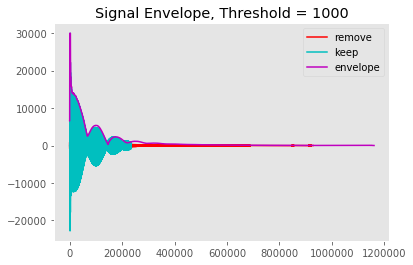

In [17]:
test_threshold(args)

In [18]:
split_wavs(args)

clean exists
clean\Acoustic_guitar does not exist


 37%|███▋      | 11/30 [00:01<00:02,  6.36it/s]

clean\Acoustic_guitar
clean\Acoustic_guitar


 63%|██████▎   | 19/30 [00:04<00:03,  2.89it/s]

clean\Acoustic_guitar


 90%|█████████ | 27/30 [00:05<00:00,  5.24it/s]

clean\Acoustic_guitar


  7%|▋         | 2/30 [00:00<00:01, 14.96it/s]

clean\Bass_drum does not exist
clean\Bass_drum
clean\Bass_drum


 13%|█▎        | 4/30 [00:00<00:01, 14.93it/s]

clean\Bass_drum
clean\Bass_drum
clean\Bass_drum


 27%|██▋       | 8/30 [00:00<00:01, 14.91it/s]

clean\Bass_drum
clean\Bass_drum


 33%|███▎      | 10/30 [00:00<00:01, 13.45it/s]

clean\Bass_drum
clean\Bass_drum


 47%|████▋     | 14/30 [00:01<00:01, 12.35it/s]

clean\Bass_drum
clean\Bass_drum


 53%|█████▎    | 16/30 [00:01<00:01, 13.05it/s]

clean\Bass_drum
clean\Bass_drum


 73%|███████▎  | 22/30 [00:01<00:00, 12.51it/s]

clean\Bass_drum
clean\Bass_drum
clean\Bass_drum
clean\Bass_drum


 87%|████████▋ | 26/30 [00:01<00:00, 14.59it/s]

clean\Bass_drum
clean\Bass_drum
clean\Bass_drum
clean\Bass_drum

 93%|█████████▎| 28/30 [00:02<00:00, 15.32it/s]


clean\Bass_drum
clean\Bass_drum


  0%|          | 0/30 [00:00<?, ?it/s]

clean\Bass_drum
clean\Cello does not exist


 17%|█▋        | 5/30 [00:01<00:05,  4.95it/s]

clean\Cello
clean\Cello


  0%|          | 0/30 [00:00<?, ?it/s]

clean\Clarinet does not exist


  0%|          | 0/30 [00:00<?, ?it/s]

clean\Double_bass does not exist


 37%|███▋      | 11/30 [00:01<00:03,  5.22it/s]

clean\Double_bass


 50%|█████     | 15/30 [00:02<00:01,  7.76it/s]

clean\Double_bass
clean\Double_bass
clean\Double_bass


 70%|███████   | 21/30 [00:02<00:01,  8.78it/s]

clean\Double_bass


 90%|█████████ | 27/30 [00:03<00:00,  7.79it/s]

clean\Double_bass


  0%|          | 0/30 [00:00<?, ?it/s]

clean\Flute does not exist


 53%|█████▎    | 16/30 [00:04<00:05,  2.38it/s]

clean\Flute


  3%|▎         | 1/30 [00:00<00:03,  8.79it/s]

clean\Hi_hat does not exist


 13%|█▎        | 4/30 [00:00<00:02,  9.75it/s]

clean\Hi_hat


 30%|███       | 9/30 [00:00<00:02, 10.14it/s]

clean\Hi_hat
clean\Hi_hat
clean\Hi_hat

 37%|███▋      | 11/30 [00:01<00:01, 10.35it/s]


clean\Hi_hat


 47%|████▋     | 14/30 [00:01<00:01,  9.06it/s]

clean\Hi_hat
clean\Hi_hat


 57%|█████▋    | 17/30 [00:01<00:01,  9.46it/s]

clean\Hi_hat
clean\Hi_hat


 70%|███████   | 21/30 [00:01<00:00, 11.32it/s]

clean\Hi_hat
clean\Hi_hat
clean\Hi_hat
clean\Hi_hat


 83%|████████▎ | 25/30 [00:02<00:00,  9.57it/s]

clean\Hi_hat


100%|██████████| 30/30 [00:03<00:00,  9.92it/s]

clean\Hi_hat



  0%|          | 0/30 [00:00<?, ?it/s]

clean\Saxophone does not exist


  0%|          | 0/30 [00:00<?, ?it/s]

clean\Snare_drum does not exist


  7%|▋         | 2/30 [00:00<00:13,  2.04it/s]

clean\Snare_drum


 30%|███       | 9/30 [00:01<00:04,  5.21it/s]

clean\Snare_drum
clean\Snare_drum
clean\Snare_drum
clean\Snare_drum


 37%|███▋      | 11/30 [00:01<00:02,  6.43it/s]

clean\Snare_drum
clean\Snare_drum
clean\Snare_drum


 57%|█████▋    | 17/30 [00:02<00:01,  7.19it/s]

clean\Snare_drum
clean\Snare_drum


 83%|████████▎ | 25/30 [00:03<00:00,  6.44it/s]

clean\Snare_drum
clean\Snare_drum
clean\Snare_drum
clean\Snare_drum


 90%|█████████ | 27/30 [00:04<00:00,  5.45it/s]

clean\Snare_drum
clean\Snare_drum


  0%|          | 0/30 [00:00<?, ?it/s]

clean\Violin_or_fiddle does not exist


 10%|█         | 3/30 [00:00<00:05,  5.23it/s]

clean\Violin_or_fiddle
clean\Violin_or_fiddle


 20%|██        | 6/30 [00:01<00:05,  4.49it/s]

clean\Violin_or_fiddle


 33%|███▎      | 10/30 [00:02<00:04,  4.51it/s]

clean\Violin_or_fiddle
clean\Violin_or_fiddle

 40%|████      | 12/30 [00:02<00:03,  5.70it/s]

 43%|████▎     | 13/30 [00:02<00:04,  3.70it/s]

clean\Violin_or_fiddle


 53%|█████▎    | 16/30 [00:03<00:02,  4.77it/s]

clean\Violin_or_fiddle


 60%|██████    | 18/30 [00:03<00:02,  5.06it/s]

clean\Violin_or_fiddle


 73%|███████▎  | 22/30 [00:04<00:01,  4.91it/s]

clean\Violin_or_fiddle
clean\Violin_or_fiddle
clean\Violin_or_fiddle


100%|██████████| 30/30 [00:06<00:00,  4.74it/s]


## Step 1.2 concatenate all the 1s data from the same class in the "clean" folder together. 

In [19]:
# Next we will concatenate the data from the same class together, which is easy for the mobile phone to play.
src_dir = 'clean'
dst_dir = 'clean'
# Read all the path from the src_dir
cls = os.listdir(src_dir)
for i in range(len(cls)):
    cls_wav_path = os.path.join(src_dir,cls[i])
    wav_paths = glob('{}/**'.format(cls_wav_path), recursive=True)
    wav_paths = [x for x in wav_paths if '.wav' in x]
    cls_wav = []
    for j in range(len(wav_paths)):
        _,tmp = wavf.read(wav_paths[j])
        cls_wav.append(tmp)
    save_wav = np.array(cls_wav).flatten()
    train_wav_len = int(0.8*len(save_wav))
    train_wav_len = int(train_wav_len-train_wav_len%44100)
    print(cls[i],train_wav_len/44100)
    print(cls[i],(len(save_wav)-train_wav_len)/44100)
    wavf.write(cls_wav_path+"_train.wav",44100,save_wav[:train_wav_len])
    wavf.write(cls_wav_path+"_test.wav",44100,save_wav[train_wav_len:])


Acoustic_guitar 68.0
Acoustic_guitar 17.0
Bass_drum 28.0
Bass_drum 7.0
Cello 72.0
Cello 18.0
Clarinet 112.0
Clarinet 29.0
Double_bass 40.0
Double_bass 10.0
Flute 124.0
Flute 32.0
Hi_hat 27.0
Hi_hat 7.0
Saxophone 141.0
Saxophone 36.0
Snare_drum 56.0
Snare_drum 14.0
Violin_or_fiddle 82.0
Violin_or_fiddle 21.0


## Step2 Training the model based on existing data

In [6]:
# Prepare the parameter for usage
parser = argparse.ArgumentParser(description='Audio Classification Training')
parser.add_argument('--model_type', type=str, default='lstm',
                        help='model to run. i.e. conv1d, conv2d, lstm')
parser.add_argument('--src_root', type=str, default='clean',
                        help='directory of audio files in total duration')
parser.add_argument('--batch_size', type=int, default=16,
                        help='batch size')
parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
parser.add_argument('--sample_rate', '-sr', type=int, default=16000,
                        help='sample rate of clean audio')
args, _ = parser.parse_known_args()

In [7]:
print(args)

Namespace(batch_size=16, delta_time=1.0, model_type='lstm', sample_rate=16000, src_root='clean')


In [8]:
src_root = args.src_root
sr = args.sample_rate
dt = args.delta_time
batch_size = args.batch_size
model_type = args.model_type

In [9]:
params = {'N_CLASSES':len(os.listdir(args.src_root)),
            'SR':sr,
            'DT':dt}
print(params)

{'N_CLASSES': 10, 'SR': 16000, 'DT': 1.0}


In [10]:
models = {'conv1d':Conv1D(**params),
            'conv2d':Conv2D(**params),
            'lstm':  LSTM(**params)}

In [11]:
assert model_type in models.keys(), '{} not an available model'.format(model_type)

In [12]:
csv_path = os.path.join('logs', '{}_history.csv'.format(model_type))

In [13]:
wav_paths = glob('{}/**'.format(src_root), recursive=True)
print(wav_paths[2])
wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x]
print(len(wav_paths))

clean\Acoustic_guitar\0356dec7_0.wav
1290


In [14]:
classes = sorted(os.listdir(args.src_root))
print(classes)

['Acoustic_guitar', 'Bass_drum', 'Cello', 'Clarinet', 'Double_bass', 'Flute', 'Hi_hat', 'Saxophone', 'Snare_drum', 'Violin_or_fiddle']


In [16]:
le = LabelEncoder()
le.fit(classes)
labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
labels = le.transform(labels)
print(labels)

[0 0 0 ... 9 9 9]


In [17]:
# The currrent wav_train and wav_val are the path to the wav file
wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
                                                                labels,
                                                                test_size=0.1,
                                                                random_state=0)

In [18]:
assert len(label_train) >= args.batch_size, 'Number of train samples must be >= batch_size'

In [19]:
print(len(set(label_train)) == params['N_CLASSES'])
print(len(set(label_val)) == params['N_CLASSES'])

True
True


In [157]:
#    def __init__(self, wav_paths, labels, sr, dt, n_classes,
#                 batch_size=32, shuffle=True):
tg = DataGenerator(wav_train, label_train, sr, dt,
                    params['N_CLASSES'], batch_size=batch_size)

## Step3: Training with my own dataset

In [5]:
# Step1: Load our wav file(60s), preprocessing to STFT as a 2D feature
# Refer to helper.py in ultramic

def load_clean_signal(file_list, file_dir):
    """Load audio files from a single mic.

    Input:
    - file_list: a list of the audio file's name, length: N. The sampling rate
    and length of each audio file should be identical.
    - filedir: name of the directory containing the audio files.

    Returns:
    - mic_array_signal: an ndarray of shape (N, L), where L is the length of the
    signal. dtype: float32.
    - fs: sampling rate.
    """
    mic_signal_list = []
    for file in file_list:
        file_path = os.path.join(file_dir, file)
        fs, single_mic_signal = wavf.read(file_path)
        mic_signal_list.append(single_mic_signal)

    single_mic_data = np.stack(mic_signal_list)
    return single_mic_data, fs

In [15]:
file_dir = "wavfiles_ultramic/Drill/"
file_list = os.listdir(file_dir)
Drill_wav,fs = load_clean_signal(file_list,file_dir)

In [16]:
file_dir = "wavfiles_ultramic/Shaver/"
file_list = os.listdir(file_dir)
Shaver_wav,fs = load_clean_signal(file_list,file_dir)

In [17]:
print("Shape of Drill wav:",Drill_wav.shape)
print("Shape of Shaver wav:",Shaver_wav.shape)
print("Fs:",fs)

Shape of Drill wav: (1, 5760000)
Shape of Shaver wav: (1, 5760000)
Fs: 96000


In [18]:
#Finish loading, then add the same normalization and gain as what we did in ultramic preprocessing
normalize_gain = (np.iinfo(Drill_wav.dtype).max +
                    1.0) / Drill_wav.max()
Drill_wav_norm = normalize_float(Drill_wav, normalize_gain)
Shaver_wav_norm = normalize_float(Shaver_wav, normalize_gain)

In [19]:
#Clip each single object file into small segment with time period 0.2s
delta_sample = int(0.2 * fs)
Drill_wav_norm = Drill_wav_norm.reshape(-1,delta_sample)
Shaver_wav_norm = Shaver_wav_norm.reshape(-1,delta_sample)
wav_stack = np.stack([Drill_wav_norm,Shaver_wav_norm])
print(wav_stack.shape)

(2, 300, 19200)


In [20]:
#Refer to ultramic code, we manually do stft on each small segment
window_len = 1024
hop_len = 512
sample_start_idx = np.arange(0,delta_sample,hop_len)

#Adjust the sample_start_idx into suitable size so that we don't need to pad zero in the end
for i in range(len(sample_start_idx)-1,-1,-1):
    if(sample_start_idx[i]+window_len<delta_sample):
        sample_start_idx = sample_start_idx[0:i+1]
        break

stft_object = []
#Iterate on Object
for n in range(wav_stack.shape[0]):
    stft_time_segment = []
    #Iterate on time segment
    for m in range(wav_stack.shape[1]):
        window_sample = np.stack([wav_stack[n,m,i:i+window_len] for i in sample_start_idx])
        f_FFT,fft_data = batch_windowed_fft(window_sample,fs)
        stft_time_segment.append(fft_data)
    stft_object.append(stft_time_segment)
print(np.stack(stft_object).shape)

(2, 300, 36, 513)


In [21]:
f_low = 16000
f_high = 40000
f_low_del = 24000
f_high_del = 26000
f_low_idx,f_high_idx = fft_freq_clipping(f_FFT, f_low, f_high)
f_low_didx,f_high_didx = fft_freq_clipping(f_FFT, f_low_del, f_high_del)
print(f_low_idx,f_high_idx)
print(f_low_didx,f_high_didx)

171 427
256 278


In [22]:
stft_object_clipping_1 = np.stack(stft_object)[:,:,:,f_low_idx:f_low_didx]
stft_object_clipping_2 = np.stack(stft_object)[:,:,:,f_high_didx:f_high_idx]
stft_object_clipping=np.abs(np.concatenate([stft_object_clipping_1,stft_object_clipping_2],axis=-1))
print(stft_object_clipping.shape)
stft_object_clipping /= np.max(stft_object_clipping)
#stft_object_clipping = np.log10(stft_object_clipping)

(2, 300, 36, 234)


In [13]:
np.save("stft_object_clipping.npy",stft_object_clipping)

## Shuffling the data so that it can achieve better performance during classification

In [5]:
from sklearn.utils import shuffle
src_root = "wavfiles_tmp"
dst_root = "wavfiles_ultramic"
wav_paths = glob('{}/**'.format(src_root), recursive=True)
wav_paths = sorted([x for x in wav_paths if ".wav" in x])
for i in range(len(wav_paths)//2):
    fs,test_tmp = wavf.read(wav_paths[2*i])
    fs,train_tmp = wavf.read(wav_paths[2*i+1])
    train_tmp = train_tmp.reshape(-1,96000)
    test_tmp = test_tmp.reshape(-1,96000)
    training_len = train_tmp.shape[0]
    tmp = np.vstack([train_tmp,test_tmp])
    tmp = shuffle(tmp)
    print(wav_paths[2*i])
    wavf.write(wav_paths[2*i+1].replace(src_root,dst_root),fs,tmp[:training_len,:].flatten())
    wavf.write(wav_paths[2*i].replace(src_root,dst_root),fs,tmp[training_len:,:].flatten())

## Step3.1: Training with the existing dataset,but use mobile phone to play

In [4]:
"""
In a single for loop, we will implement the follwing job:
1. Read the assmebled wav into the program
2. Get the length(s/sample) of this wav file
3. Manully apply the STFT to a single frame(1s)
4. Manully add the label into the list corresponding to each second
"""
# Step1: Read the wav file in and label in
src_root = "wavfiles_ultramic"
wav_paths = glob('{}/**'.format(src_root), recursive=True)
wav_paths = [x for x in wav_paths if "Train.wav" in x]
labels = [os.path.split(x)[-1].split('_T')[0] for x in wav_paths]
print("Wav source file paths:",wav_paths)
print("Labels are:",labels)


Wav source file paths: ['wavfiles_ultramic\\Acoustic_guitar_Train.wav', 'wavfiles_ultramic\\Bass_drum_Train.wav', 'wavfiles_ultramic\\Cello_Train.wav', 'wavfiles_ultramic\\Clarinet_Train.wav', 'wavfiles_ultramic\\Double_bass_Train.wav', 'wavfiles_ultramic\\Flute_Train.wav', 'wavfiles_ultramic\\Hi_hat_Train.wav', 'wavfiles_ultramic\\None_Train.wav', 'wavfiles_ultramic\\Saxophone_Train.wav', 'wavfiles_ultramic\\Snare_drum_Train.wav', 'wavfiles_ultramic\\Violin_or_fiddle_Train.wav']
Labels are: ['Acoustic_guitar', 'Bass_drum', 'Cello', 'Clarinet', 'Double_bass', 'Flute', 'Hi_hat', 'None', 'Saxophone', 'Snare_drum', 'Violin_or_fiddle']


In [8]:
# This training data is for all eleven classes, and use manual fft to do the stft
train_data = []
train_label = []
fs = 96000
window_len = int(0.04*fs)
hop_len = window_len//2
delta_sample = int(1*fs)
sample_start_idx = np.arange(0,delta_sample,hop_len)
#Adjust the sample_start_idx into suitable size so that we don't need to pad zero in the end
for i in range(len(sample_start_idx)-1,-1,-1):
    if(sample_start_idx[i]+window_len<delta_sample):
        sample_start_idx = sample_start_idx[0:i+1]
        break

for i in range(len(wav_paths)):
    cur_path = wav_paths[i]
    cur_label = labels[i]
    fs,cur_wav = wavf.read(cur_path)
    print("Current Object is:",cur_label)
    print("Number of training instance of current object:",len(cur_wav))
    cur_wav = cur_wav.reshape(-1,delta_sample)
    normalize_gain = (np.iinfo(cur_wav.dtype).max +
                    1.0) / cur_wav.max()
    cur_wav_norm = normalize_float(cur_wav, normalize_gain)
    print(cur_wav_norm.shape)
    for j in range(cur_wav_norm.shape[0]):
        window_sample = np.stack([cur_wav_norm[j,k:k+window_len] for k in sample_start_idx])
        f_FFT,fft_data = batch_windowed_fft(window_sample,fs)
        #train_data.append(np.abs(fft_data))
        train_data.append(fft_data)
        train_label.append(labels[i])
train_data = np.stack(train_data)
print(train_data.shape)
print(len(train_label))    

Current Object is: Acoustic_guitar
Number of training instance of current object: 6528000
(68, 96000)
Current Object is: Bass_drum
Number of training instance of current object: 2688000
(28, 96000)
Current Object is: Cello
Number of training instance of current object: 6912000
(72, 96000)
Current Object is: Clarinet
Number of training instance of current object: 10752000
(112, 96000)
Current Object is: Double_bass
Number of training instance of current object: 3840000
(40, 96000)
Current Object is: Flute
Number of training instance of current object: 11904000
(124, 96000)
Current Object is: Hi_hat
Number of training instance of current object: 2592000
(27, 96000)
Current Object is: None
Number of training instance of current object: 9600000
(100, 96000)
Current Object is: Saxophone
Number of training instance of current object: 13536000
(141, 96000)
Current Object is: Snare_drum
Number of training instance of current object: 5376000
(56, 96000)
Current Object is: Violin_or_fiddle
Numbe

In [22]:
np.save("npy_files/Train.npy",train_data)
np.save("npy_files/Test_label.npy",train_label)

In [9]:
"""
In a single for loop, we will implement the follwing job:
1. Read the assmebled wav into the program
2. Get the length(s/sample) of this wav file
3. Manully apply the STFT to a single frame(1s)
4. Manully add the label into the list corresponding to each second
"""
#This training data is for four classes,Cello,Clarinet,Flute,None and use signal.stft so the ML model size is ...50,1921
# Step1: Read the wav file in and label in
src_root = "wavfiles_ultramic"
wav_paths = glob('{}/**'.format(src_root), recursive=True)
wav_paths = [x for x in wav_paths if "Train.wav" in x]
wav_paths = [x for x in wav_paths if ("Cello" in x or "Clarinet" in x or "Flute" in x or "None" in x)]
labels = [os.path.split(x)[-1].split('_T')[0] for x in wav_paths]
print("Wav source file paths:",wav_paths)
print("Labels are:",labels)


Wav source file paths: ['wavfiles_ultramic\\Cello_Train.wav', 'wavfiles_ultramic\\Clarinet_Train.wav', 'wavfiles_ultramic\\Flute_Train.wav', 'wavfiles_ultramic\\None_Train.wav']
Labels are: ['Cello', 'Clarinet', 'Flute', 'None']


In [10]:
train_data = []
train_label = []
fs = 96000
window_len = int(0.04*fs)
hop_len = window_len//2
delta_sample = int(1*fs)
sample_start_idx = np.arange(0,delta_sample,hop_len)
#Adjust the sample_start_idx into suitable size so that we don't need to pad zero in the end
for i in range(len(sample_start_idx)-1,-1,-1):
    if(sample_start_idx[i]+window_len<delta_sample):
        sample_start_idx = sample_start_idx[0:i+1]
        break

for i in range(len(wav_paths)):
    cur_path = wav_paths[i]
    cur_label = labels[i]
    fs,cur_wav = wavf.read(cur_path)
    print("Current Object is:",cur_label)
    print("Number of training instance of current object:",len(cur_wav))
    cur_wav = cur_wav.reshape(-1,delta_sample)
    normalize_gain = (np.iinfo(cur_wav.dtype).max +
                    1.0) / cur_wav.max()
    cur_wav_norm = normalize_float(cur_wav, normalize_gain)
    print(cur_wav_norm.shape)
    for j in range(cur_wav_norm.shape[0]):
        window_sample = np.stack([cur_wav_norm[j,k:k+window_len] for k in sample_start_idx])
        f_FFT,fft_data = batch_windowed_fft(window_sample,fs)
        #train_data.append(np.abs(fft_data))
        train_data.append(fft_data)
        train_label.append(labels[i])
train_data = np.stack(train_data)
print(train_data.shape)
print(len(train_label))    

Current Object is: Cello
Number of training instance of current object: 6912000
(72, 96000)
Current Object is: Clarinet
Number of training instance of current object: 10752000
(112, 96000)
Current Object is: Flute
Number of training instance of current object: 11904000
(124, 96000)
Current Object is: None
Number of training instance of current object: 9600000
(100, 96000)
(408, 48, 1921)
408


In [11]:
print(train_label)

['Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Cello', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Clarinet', 'Cl

In [12]:
np.save("npy_files/Train_with_4.npy",train_data)
np.save("npy_files/Train_with_4_label.npy",train_label)